<a href="https://colab.research.google.com/github/peterbabulik/OTOCs/blob/main/OTOCs_as_a_Measure_of_Circuit_Complexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cirq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.2 MB/s eta 0:00:00


Measuring OTOC vs. Circuit Depth for a 12-qubit system.
Averaging over 1000 random circuit instances per depth.
Depth:  0, Avg. OTOC Proxy = 0.0010
Depth:  1, Avg. OTOC Proxy = 0.0000
Depth:  2, Avg. OTOC Proxy = -0.0003
Depth:  3, Avg. OTOC Proxy = 0.0001
Depth:  4, Avg. OTOC Proxy = -0.0002
Depth:  5, Avg. OTOC Proxy = 0.0001
Depth:  6, Avg. OTOC Proxy = -0.0002
Depth:  7, Avg. OTOC Proxy = -0.0000
Depth:  8, Avg. OTOC Proxy = 0.0006
Depth:  9, Avg. OTOC Proxy = -0.0008
Depth: 10, Avg. OTOC Proxy = -0.0012
Depth: 11, Avg. OTOC Proxy = -0.0003
Depth: 12, Avg. OTOC Proxy = 0.0008
Depth: 13, Avg. OTOC Proxy = 0.0005
Depth: 14, Avg. OTOC Proxy = 0.0001
Depth: 15, Avg. OTOC Proxy = 0.0007
Depth: 16, Avg. OTOC Proxy = -0.0004
Depth: 17, Avg. OTOC Proxy = 0.0004
Depth: 18, Avg. OTOC Proxy = -0.0013
Depth: 19, Avg. OTOC Proxy = -0.0007
Depth: 20, Avg. OTOC Proxy = 0.0000
Simulation complete!


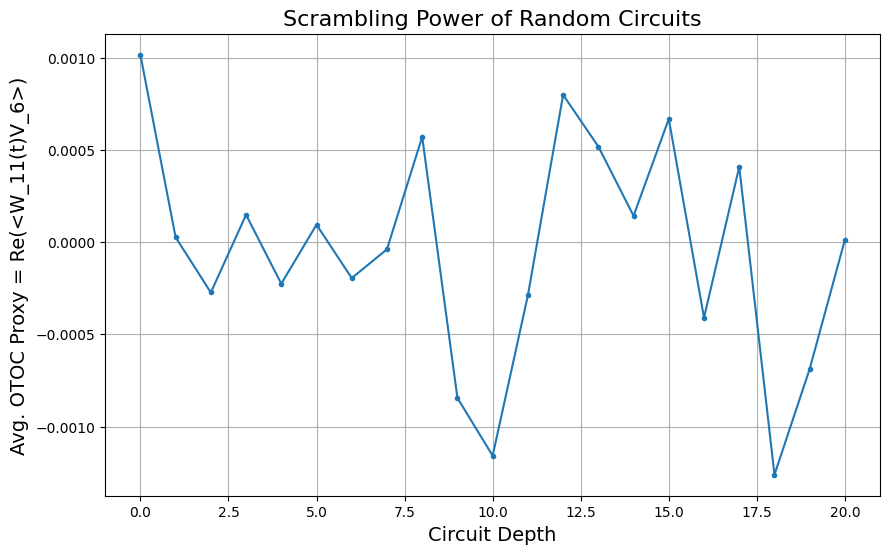

In [3]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the Random Circuit Generator ---

def generate_random_layer(qubits):
    """Yields a layer of random single-qubit rotations and a layer of CZ gates."""
    # Layer of random single-qubit gates
    # Using PhasedXPowGate is a good general choice for random rotations
    for qubit in qubits:
        yield cirq.PhasedXPowGate(
            phase_exponent=np.random.uniform(0, 1),
            exponent=0.5 # A common choice, like an H-gate with a phase
        ).on(qubit)

    # Layer of entangling gates (CZ)
    # Apply CZs in a staggered pattern to entangle all neighbors
    for i in range(0, len(qubits) - 1, 2):
        yield cirq.CZ(qubits[i], qubits[i+1])
    for i in range(1, len(qubits) - 1, 2):
        yield cirq.CZ(qubits[i], qubits[i+1])

# --- 2. Ancilla-Based OTOC Simulation with Random Circuits ---

# System Parameters
N = 12
system_qubits = cirq.LineQubit.range(N)
ancilla = cirq.GridQubit(0, N)

# Operators and sites
op_W = cirq.X
op_V = cirq.Z
w_site = N - 1
v_site = N // 2

# Simulation Parameters
max_depth = 20
depth_steps = np.arange(0, max_depth + 1)
otoc_proxy_values = []
repetitions = 4000  # Shots per measurement
num_instances = 1000  # Number of random circuits to average over for each depth

print(f"Measuring OTOC vs. Circuit Depth for a {N}-qubit system.")
print(f"Averaging over {num_instances} random circuit instances per depth.")

simulator = cirq.Simulator()

for depth in depth_steps:

    # Store results for each random instance at this depth
    instance_results = []

    for instance_num in range(num_instances):
        # Build the forward and backward evolution circuits for this specific instance
        # For depth > 0, we generate the circuit
        if depth > 0:
            forward_evolution = cirq.Circuit(generate_random_layer(system_qubits) for _ in range(depth))
            backward_evolution = cirq.inverse(forward_evolution)
        # For depth = 0, the circuit is empty
        else:
            forward_evolution = cirq.Circuit()
            backward_evolution = cirq.Circuit()

        # Construct the full interferometric circuit
        otoc_circuit = cirq.Circuit(
            cirq.H(ancilla),
            op_V(system_qubits[v_site]).controlled_by(ancilla),
            forward_evolution,
            op_W(system_qubits[w_site]).controlled_by(ancilla),
            backward_evolution,
            cirq.H(ancilla),
            cirq.measure(ancilla, key='ancilla_meas')
        )

        # Run the simulation for many shots
        result = simulator.run(otoc_circuit, repetitions=repetitions)
        counts = result.histogram(key='ancilla_meas')
        expectation_value_z = (counts.get(0, 0) - counts.get(1, 0)) / repetitions
        instance_results.append(expectation_value_z)

    # Average the results from all random instances for this depth
    avg_otoc_proxy = np.mean(instance_results)
    otoc_proxy_values.append(avg_otoc_proxy)

    print(f"Depth: {depth:2d}, Avg. OTOC Proxy = {avg_otoc_proxy:.4f}")

print("Simulation complete!")

# --- 3. Plot the Results ---
plt.figure(figsize=(10, 6))
plt.plot(depth_steps, otoc_proxy_values, marker='.', linestyle='-')
plt.xlabel("Circuit Depth", fontsize=14)
plt.ylabel(f"Avg. OTOC Proxy = Re(<W_{w_site}(t)V_{v_site}>)", fontsize=14)
plt.title(f"Scrambling Power of Random Circuits", fontsize=16)
plt.grid(True)
plt.show()